In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")
products = pd.read_csv("Products.csv")


In [2]:
customers.head()

,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10
1,C0002,Elizabeth Lutz,Asia,2022-02-13
2,C0003,Michael Rivera,South America,2024-03-07
3,C0004,Kathleen Rodriguez,South America,2022-10-09
4,C0005,Laura Weber,Asia,2022-08-15


In [3]:
transactions.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68


In [4]:
products.head()

,ProductID,ProductName,Category,Price
0,P001,ActiveWear Biography,Books,169.30
1,P002,ActiveWear Smartwatch,Electronics,346.30
2,P003,ComfortLiving Biography,Books,44.12
3,P004,BookWorld Rug,Home Decor,95.69
4,P005,TechPro T-Shirt,Clothing,429.31


In [5]:
# Merge datasets for analysis
merged_data = transactions.merge(customers, on="CustomerID").merge(products, on="ProductID")


In [6]:
# Feature Engineering
# 1. Total spend per customer
customer_spend = merged_data.groupby("CustomerID")["TotalValue"].sum().rename("TotalSpend")

# 2. Average transaction value per customer
avg_transaction_value = merged_data.groupby("CustomerID")["TotalValue"].mean().rename("AvgTransactionValue")

# 3. Purchase frequency (total transactions per customer)
purchase_frequency = merged_data.groupby("CustomerID").size().rename("PurchaseFrequency")


In [7]:
# 4. Preferred product category (most purchased category for each customer)
def preferred_category(group):
    return group.groupby("Category")["Quantity"].sum().idxmax()

In [8]:
preferred_category = merged_data.groupby("CustomerID").apply(preferred_category).rename("PreferredCategory")


In [9]:
# Combine all features into a single DataFrame
customer_features = pd.concat([customer_spend, avg_transaction_value, purchase_frequency, preferred_category], axis=1)

# One-hot encode the preferred category
customer_features = pd.get_dummies(customer_features, columns=["PreferredCategory"], drop_first=True)


In [10]:
# Normalize numerical features
scaler = StandardScaler()
numerical_features = ["TotalSpend", "AvgTransactionValue", "PurchaseFrequency"]
customer_features[numerical_features] = scaler.fit_transform(customer_features[numerical_features])


In [11]:
# Optimal Number of Clusters using Elbow Method
sse = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(customer_features)
    sse.append(kmeans.inertia_)

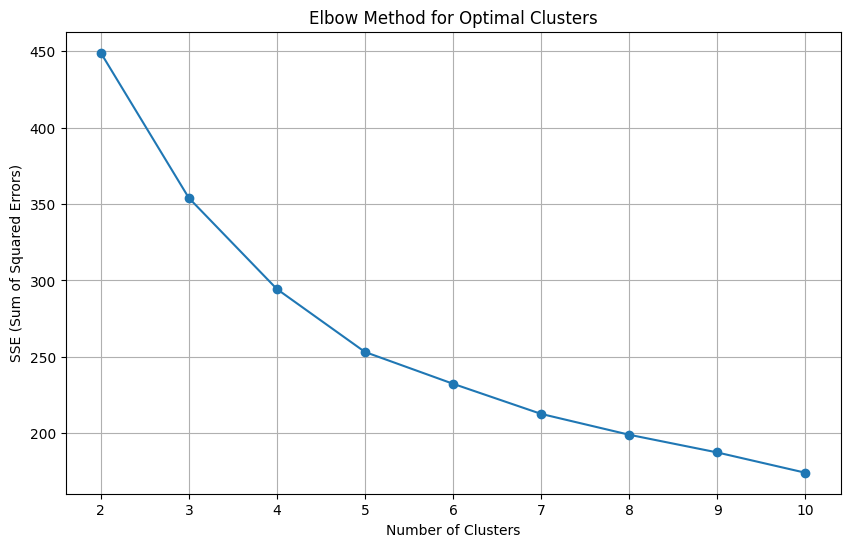

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker="o")
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("SSE (Sum of Squared Errors)")
plt.grid(True)
plt.show()

In [13]:
# Choose optimal clusters (e.g., k=4 based on the elbow method)
k_optimal = 4
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
kmeans.fit(customer_features)
customer_features["Cluster"] = kmeans.labels_

In [14]:
# Evaluate Clustering with Davies-Bouldin Index
db_index = davies_bouldin_score(customer_features[numerical_features], customer_features["Cluster"])
print(f"Davies-Bouldin Index: {db_index}")

Davies-Bouldin Index: 0.917511534255353


In [15]:
# Visualize Clusters using PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(customer_features[numerical_features])
customer_features["PCA1"] = pca_features[:, 0]
customer_features["PCA2"] = pca_features[:, 1]

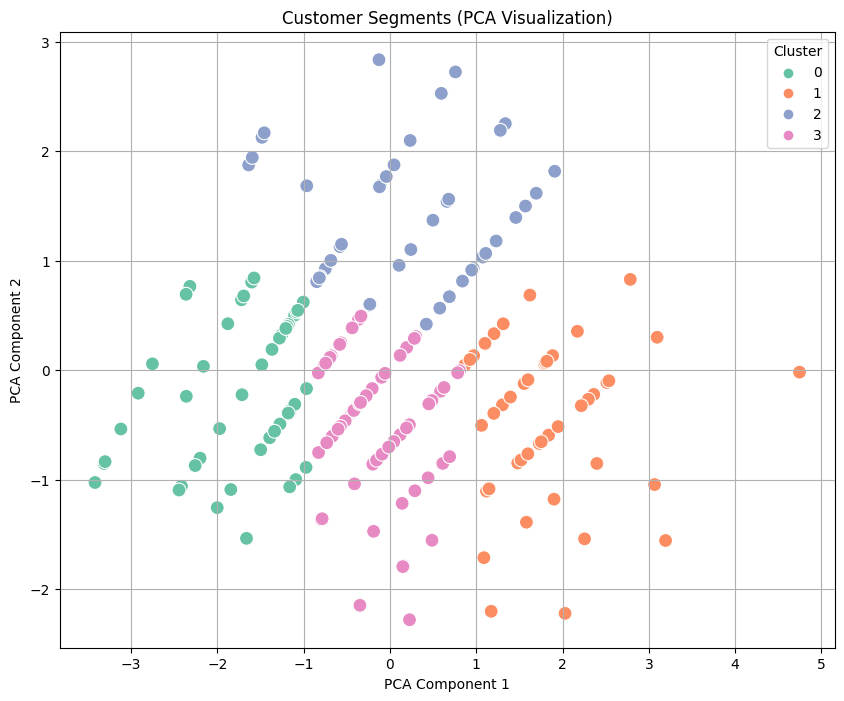

In [18]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=customer_features,
    x="PCA1", y="PCA2",
    hue="Cluster",
    palette="Set2",
    s=100
)
plt.title("Customer Segments (PCA Visualization)")+-
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

In [19]:
# Save clustering results
customer_features[["TotalSpend", "AvgTransactionValue", "PurchaseFrequency", "Cluster"]].to_csv("Customer_Clusters.csv", index=False)
